In [1]:
import pandas as pd
import numpy as np
import os
import sys

#!pip install librosa
#!pip install lifelines
#!pip install np_utils
#!pip install tensorflow

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt


import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

## Importing and Splitting the datasets

In [2]:
#importing the datasets (train_set_augmented for all landmarks, train_set_augmented_simplified for simplified landmarks)
train_set = pd.read_csv('outputs/train_set_augmented_left.csv')
test_set = pd.read_csv('outputs/test_set_augmented_left.csv')

In [3]:
#Split into features and target; x = features, y = target
x_train = train_set.iloc[:, 1:]
y_train = train_set['label']

x_test = test_set.iloc[:, 1:]
y_test = test_set['label']

In [4]:
x_test

,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,lm_3_y,lm_3_z,lm_4_x,...,lm_243_z,lm_244_x,lm_244_y,lm_244_z,lm_245_x,lm_245_y,lm_245_z,lm_246_x,lm_246_y,lm_246_z
0,0.508892,0.280521,-0.061310,0.528640,0.357668,-0.074109,0.535282,0.396106,-0.067197,0.543087,...,-0.043563,0.568307,0.879690,-0.038823,0.568481,0.924591,-0.039270,0.568897,0.963173,-0.024857
1,0.517191,0.277065,-0.025698,0.515960,0.354185,-0.043776,0.515340,0.389386,-0.042554,0.515228,...,-0.051817,0.448840,0.834760,-0.046515,0.439707,0.868215,-0.045022,0.432530,0.900748,-0.033704
2,0.565584,0.239177,-0.158353,0.561012,0.314114,-0.140281,0.556071,0.357632,-0.120230,0.551921,...,0.044249,0.458034,0.797593,0.060385,0.447597,0.825525,0.071443,0.440810,0.844089,0.095992
3,0.427854,0.261546,-0.222509,0.444436,0.365391,-0.196464,0.452353,0.402529,-0.169406,0.458734,...,0.105761,0.543017,0.917809,0.138140,0.538867,0.956698,0.165551,0.543012,0.987354,0.199632
4,0.452889,0.271014,-0.055722,0.464855,0.351958,-0.069770,0.471369,0.389812,-0.064000,0.478293,...,-0.019857,0.498926,0.875204,-0.012618,0.494905,0.913990,-0.008388,0.496813,0.946017,0.007108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,0.505463,0.337007,-0.043781,0.505736,0.391256,-0.050417,0.505004,0.425628,-0.044420,0.504782,...,-0.016472,0.462178,0.762636,-0.013440,0.454568,0.783686,-0.013317,0.450755,0.799481,-0.001606
6197,0.447904,0.316726,-0.015389,0.457909,0.375309,-0.029667,0.464293,0.411438,-0.028090,0.471311,...,-0.029154,0.489625,0.831416,-0.023764,0.487827,0.861394,-0.020357,0.491148,0.885443,-0.009662
6198,0.478635,0.341023,-0.071596,0.487617,0.394630,-0.071386,0.492375,0.428148,-0.061811,0.498286,...,0.007005,0.504986,0.774690,0.013880,0.500907,0.795734,0.017813,0.499994,0.811359,0.032485
6199,0.508651,0.328887,-0.038537,0.516994,0.399248,-0.053676,0.518036,0.430118,-0.048861,0.519270,...,-0.032032,0.500287,0.835797,-0.031399,0.492652,0.868385,-0.034758,0.487166,0.895398,-0.023305


In [5]:
y_test

0         happy
1         happy
2         happy
3         happy
4         happy
         ...   
6196    neutral
6197    neutral
6198    neutral
6199    neutral
6200    neutral
Name: label, Length: 6201, dtype: object

In [6]:
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

#Get the labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

y_test

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [7]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [8]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((28263, 738, 1), (28263, 4), (6201, 738, 1), (6201, 4))

In [9]:
def init_model(x_train):
    model= Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    
    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.2))
    
    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.2))
    
    model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    
    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(units=4, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    return model


model = init_model(x_train)
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 738, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 369, 256)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 369, 128)          163968    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 185, 128)          0         
 g1D)                                                            
                                                                 
 dropout (Dropout)           (None, 185, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 185, 64)         

In [10]:
def train_model(model, folder, x_train, y_train, x_test, y_test):
    checkpoint_filepath = os.getcwd() + '/' + folder + '/Epoch{epoch:02d}_{accuracy:.2f}.keras'
    checkpoint_filepath

    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='max')

    early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.8, verbose=1, patience=2, min_lr=0.0001)

    history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[model_checkpoint_callback, early_stopping_callback, rlrp])
    return history

In [11]:
history = train_model(model, 'ckpt_cnn',  x_train, y_train, x_test, y_test)

Epoch 1/50


442/442 [==============================] - 44s 95ms/step - loss: 1.1562 - accuracy: 0.4751 - val_loss: 0.9576 - val_accuracy: 0.5901 - lr: 0.0010
Epoch 2/50
442/442 [==============================] - 40s 91ms/step - loss: 1.0096 - accuracy: 0.5455 - val_loss: 0.9057 - val_accuracy: 0.6152 - lr: 0.0010
Epoch 3/50
442/442 [==============================] - 40s 91ms/step - loss: 0.9688 - accuracy: 0.5681 - val_loss: 0.9042 - val_accuracy: 0.6101 - lr: 0.0010
Epoch 4/50
442/442 [==============================] - 40s 91ms/step - loss: 0.9426 - accuracy: 0.5772 - val_loss: 0.8569 - val_accuracy: 0.6331 - lr: 0.0010
Epoch 5/50
442/442 [==============================] - 40s 90ms/step - loss: 0.9311 - accuracy: 0.5868 - val_loss: 0.8574 - val_accuracy: 0.6305 - lr: 0.0010
Epoch 6/50
442/442 [==============================] - 40s 91ms/step - loss: 0.9138 - accuracy: 0.5921 - val_loss: 0.8472 - val_accuracy: 0.6480 - lr: 0.0010
Epoch 7/50
442/442 [==============================] - 41

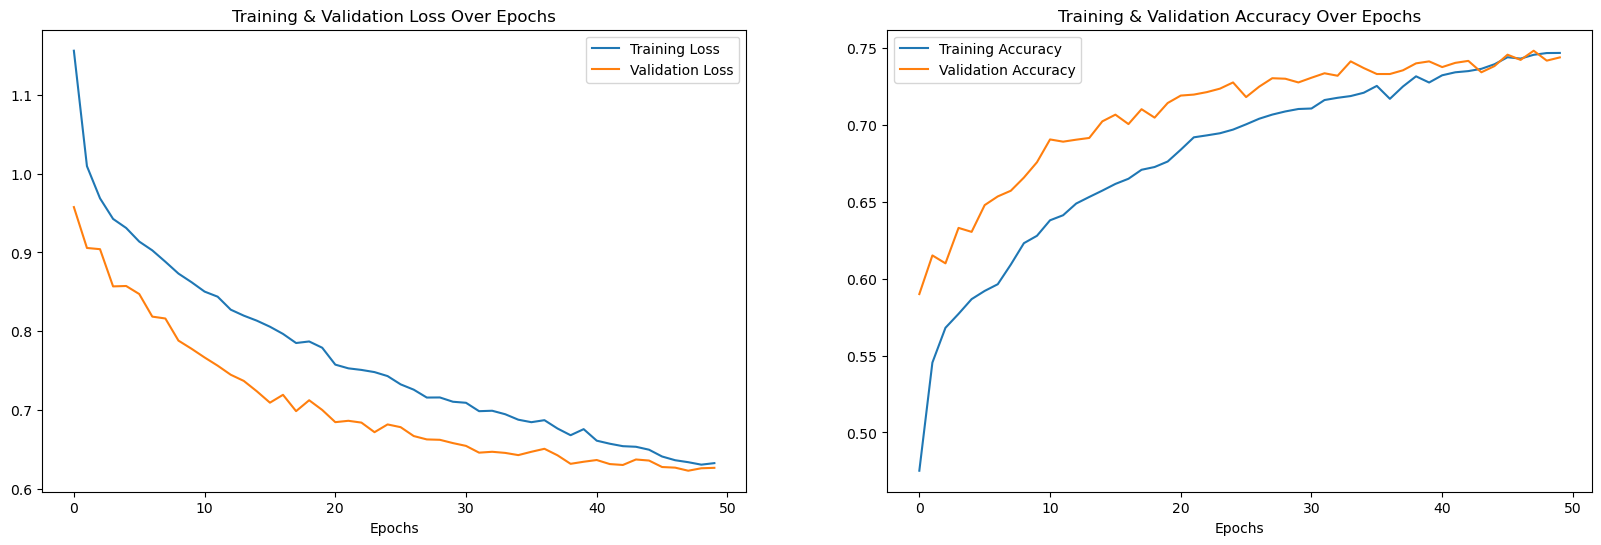

In [13]:
epochs = [i for i in range(50)]
fig, ax = plt.subplots(1,2)
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
test_accuracy = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs, train_loss, label = 'Training Loss')
ax[0].plot(epochs, test_loss, label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss Over Epochs')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_accuracy, label = 'Training Accuracy')
ax[1].plot(epochs, test_accuracy, label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy Over Epochs')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [14]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

194/194 [==============================] - 2s 11ms/step


In [15]:
y_pred

array([['anger'],
       ['sad'],
       ['sad'],
       ...,
       ['neutral'],
       ['neutral'],
       ['neutral']], dtype=object)

        anger happy neutral  sad
anger    1171    32     223  215
happy      29  1588      99   56
neutral   143    40     987  198
sad       201    45     306  868


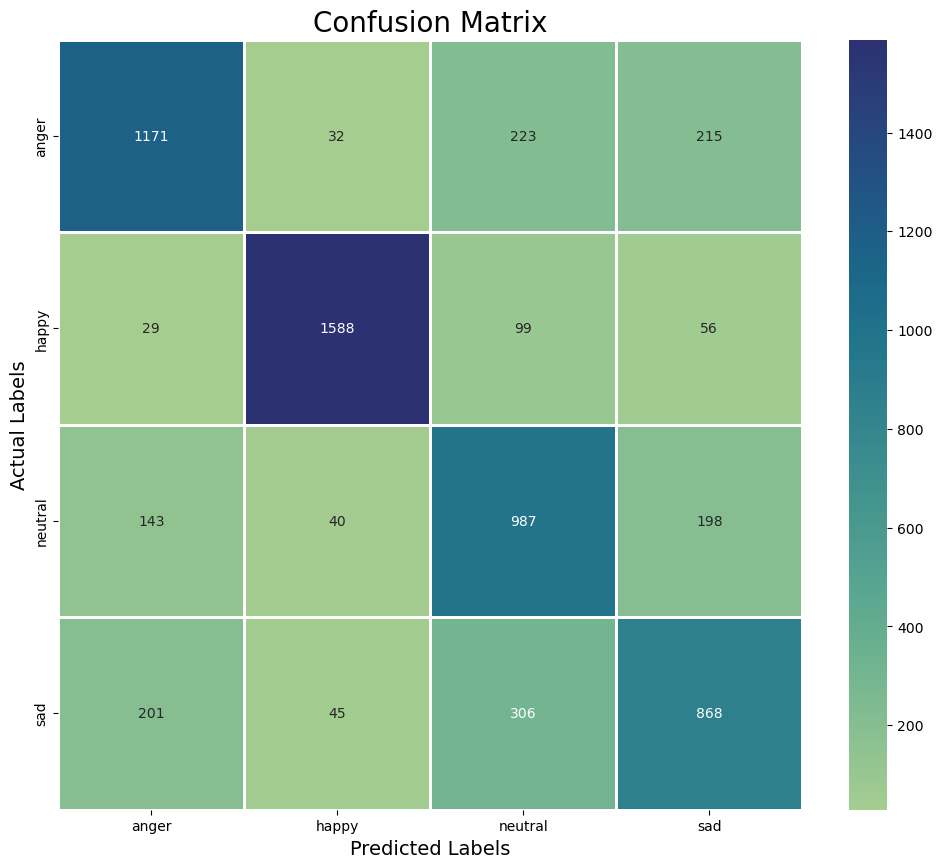

In [16]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='crest', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
print(cm)
plt.show()

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

acs_test = accuracy_score(y_test,y_pred)
ps_test = precision_score(y_test,y_pred, average = "macro")
rs_test = recall_score(y_test,y_pred,  average = "macro")
fs_test = f1_score(y_test,y_pred,  average = "macro")

print("Accuracy Score: ", "{:.2%}".format(acs_test))
print("Precision Score: ", "{:.2%}".format(ps_test))
print("Recall Score: ", "{:.2%}".format(rs_test))
print("F1 Score: ", "{:.2%}".format(fs_test))

Accuracy Score:  74.41%
Precision Score:  73.75%
Recall Score:  73.56%
F1 Score:  73.50%


In [18]:
#K fold Cross Validation Module

#1. Get all rows together
all_data_df = pd.concat([train_set, test_set])
num_rows = len(all_data_df.index)

In [19]:
#2. Shuffle rows
all_data_df = all_data_df.sample(frac=1).reset_index()
all_data_df = all_data_df.drop(columns=['index'])    

In [20]:
#K fold cross validation for k=5 (5 runs)
fold_num_rows = num_rows // 5
last_fold_num_rows = num_rows - (fold_num_rows * 4)

confusion_matrices = []
scores = []
for i in range(0, 5):
    #Get number of rows to retrieve
    start = i * fold_num_rows
    end = (i + 1) * fold_num_rows
    if i == 4:
        end = num_rows

    print("K =", str(i+1), "getting images from", str(start), "to", str(end))
    
    #Construct train and test split using iloc
    test_df = all_data_df.iloc[start:end, : ]
    train_df = pd.concat([all_data_df, test_df]).drop_duplicates(keep=False)

    x_train = train_df.iloc[:, 1:]
    y_train = train_df['label']
    
    x_test = test_df.iloc[:, 1:]
    y_test = test_df['label']

    encoder = OneHotEncoder()
    y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
    y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    x_train = np.expand_dims(x_train, axis=2)
    x_test = np.expand_dims(x_test, axis=2)

    #Train the model
    model = init_model(x_train)
    history = train_model(model, 'ckpt_cnn_k' + str(i+1), x_train, y_train, x_test, y_test)

    #Evaluate the model
    pred_test = model.predict(x_test)
    y_pred = encoder.inverse_transform(pred_test)
    y_test = encoder.inverse_transform(y_test)

    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
    
    acs_test = accuracy_score(y_test,y_pred)
    ps_test = precision_score(y_test,y_pred, average = "macro")
    rs_test = recall_score(y_test,y_pred,  average = "macro")
    fs_test = f1_score(y_test,y_pred,  average = "macro")

    fold_score = {
        "accuracy": acs_test,
        "precision": ps_test,
        "recall": rs_test,
        "f1": fs_test
    }

    #Save the scores
    confusion_matrices.append(cm)
    scores.append(fold_score)

K = 1 getting images from 0 to 6892
Epoch 1/50
395/395 [==============================] - 39s 96ms/step - loss: 1.1678 - accuracy: 0.4719 - val_loss: 1.0344 - val_accuracy: 0.5634 - lr: 0.0010
Epoch 2/50
395/395 [==============================] - 41s 104ms/step - loss: 1.0122 - accuracy: 0.5384 - val_loss: 0.9736 - val_accuracy: 0.5779 - lr: 0.0010
Epoch 3/50
395/395 [==============================] - 43s 109ms/step - loss: 0.9804 - accuracy: 0.5594 - val_loss: 0.9237 - val_accuracy: 0.5976 - lr: 0.0010
Epoch 4/50
395/395 [==============================] - 44s 112ms/step - loss: 0.9618 - accuracy: 0.5768 - val_loss: 0.9410 - val_accuracy: 0.5969 - lr: 0.0010
Epoch 5/50
395/395 [==============================] - 44s 111ms/step - loss: 0.9509 - accuracy: 0.5834 - val_loss: 0.9077 - val_accuracy: 0.5913 - lr: 0.0010
Epoch 6/50
395/395 [==============================] - 42s 106ms/step - loss: 0.9286 - accuracy: 0.5957 - val_loss: 0.8977 - val_accuracy: 0.6065 - lr: 0.0010
Epoch 7/50
395/39

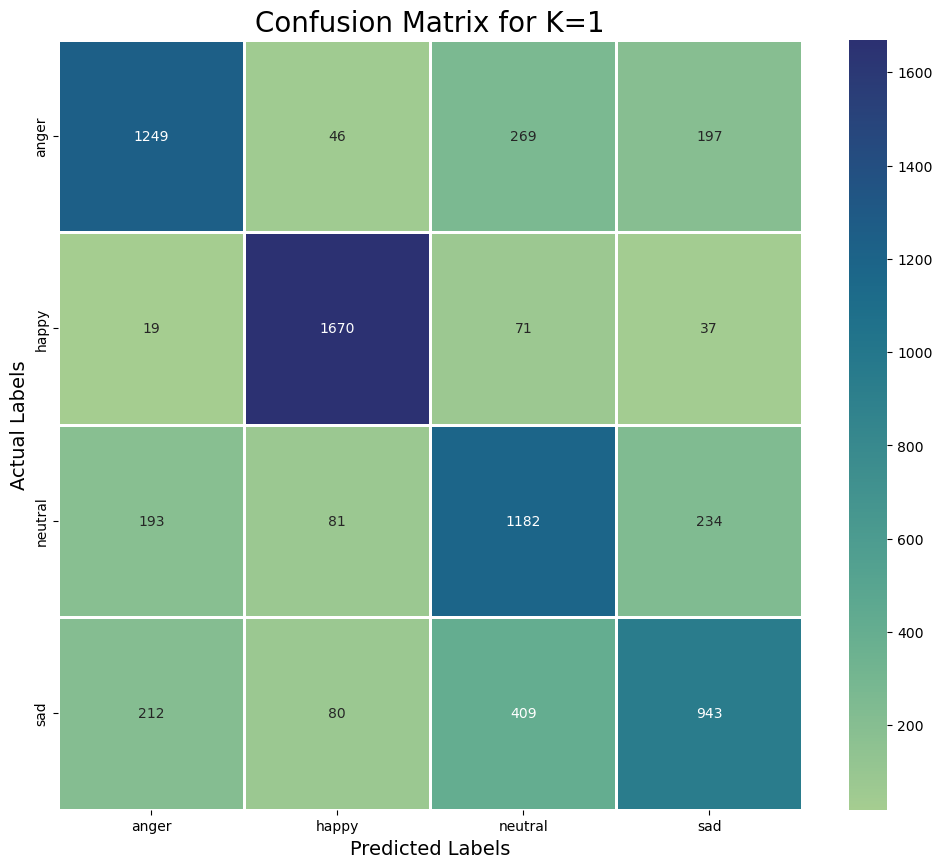

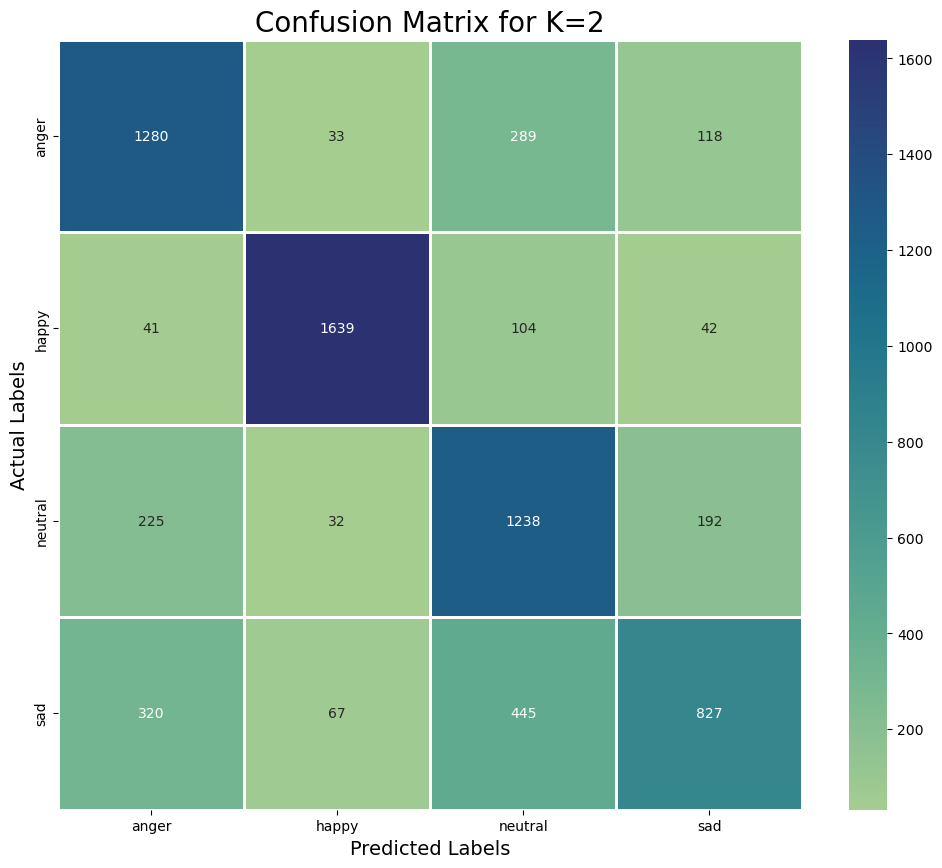

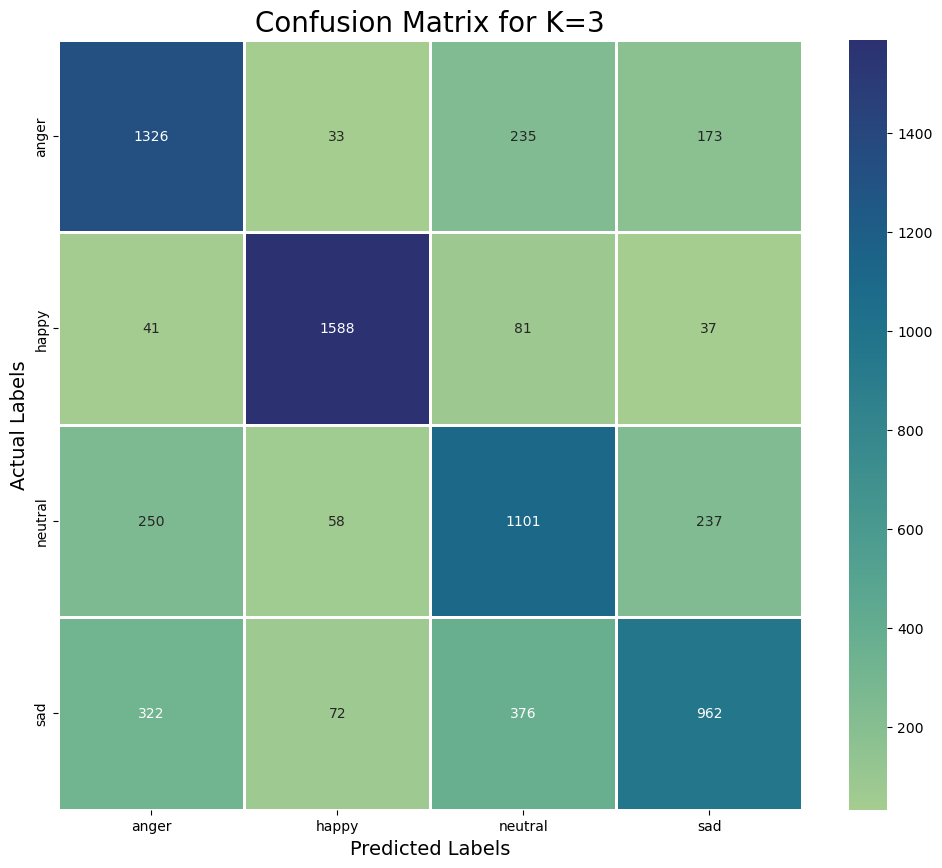

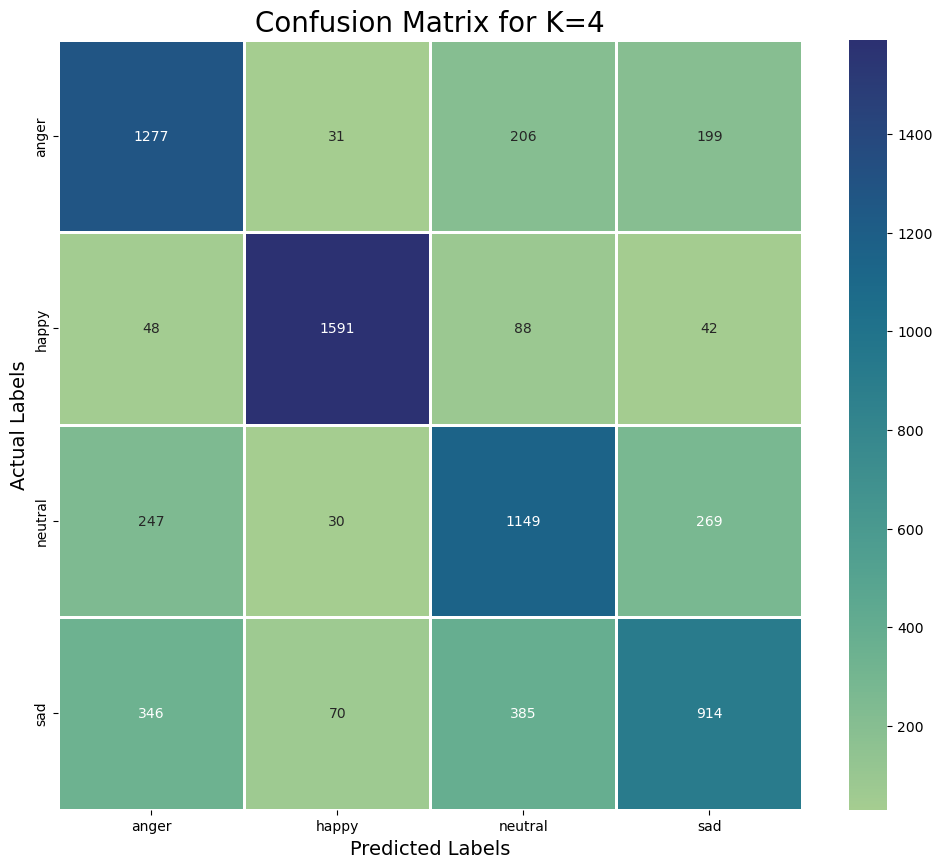

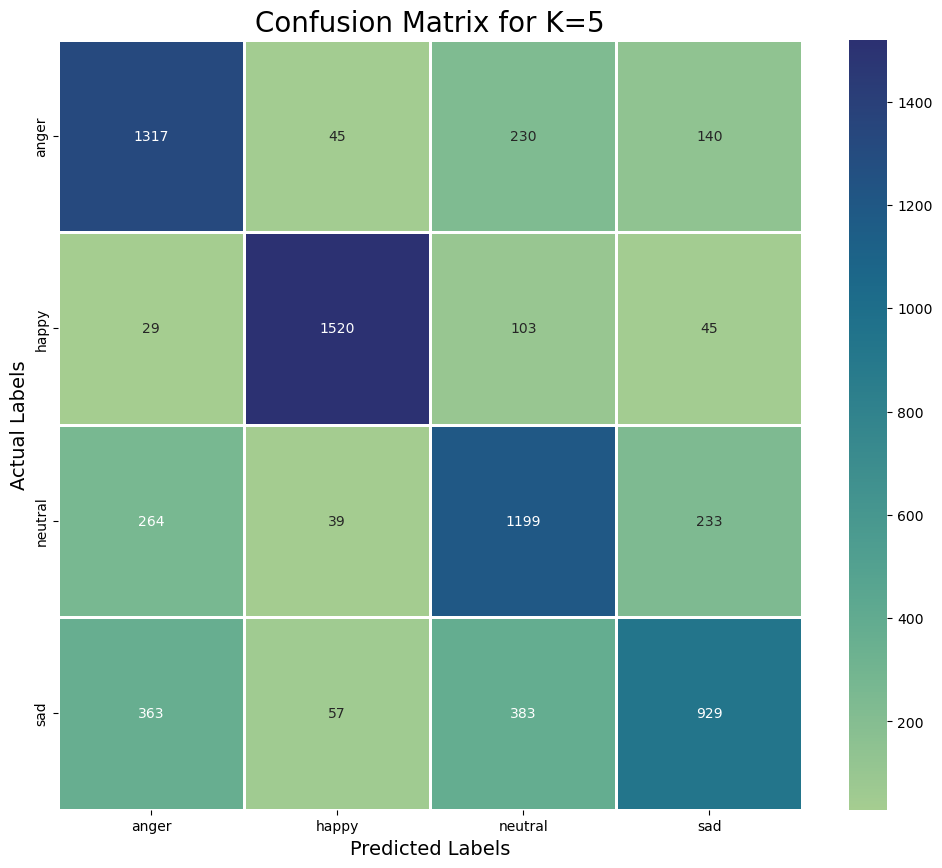

In [21]:
#Show each result in confusion matrix
for i in range(len(confusion_matrices)):
    cm = confusion_matrices[i]
    plt.figure(figsize = (12, 10))
    sns.heatmap(cm, linecolor='white', cmap='crest', linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix for K='+str(i+1), size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)

In [22]:
#Show each score and summarize results

cross_val_score = {
    "accuracy": 0,
    "precision": 0,
    "recall": 0,
    "f1": 0
}
for i in range(len(scores)):
    acs_test = scores[i]['accuracy']
    ps_test = scores[i]['precision']
    rs_test = scores[i]['recall']
    fs_test = scores[i]['f1']
    
    print("Score Summary for K =",str(i+1))
    print("Accuracy Score: ", "{:.2%}".format(acs_test))
    print("Precision Score: ", "{:.2%}".format(ps_test))
    print("Recall Score: ", "{:.2%}".format(rs_test))
    print("F1 Score: ", "{:.2%}".format(fs_test))

    cross_val_score['accuracy'] += acs_test
    cross_val_score['precision'] += ps_test
    cross_val_score['recall'] += rs_test
    cross_val_score['f1'] += fs_test

cross_val_score['accuracy'] /= 5
cross_val_score['precision'] /= 5
cross_val_score['recall'] /= 5
cross_val_score['f1'] /= 5

Score Summary for K = 1
Accuracy Score:  73.19%
Precision Score:  72.92%
Recall Score:  72.79%
F1 Score:  72.67%
Score Summary for K = 2
Accuracy Score:  72.32%
Precision Score:  72.73%
Recall Score:  71.85%
F1 Score:  71.65%
Score Summary for K = 3
Accuracy Score:  72.21%
Precision Score:  72.19%
Recall Score:  72.09%
F1 Score:  71.91%
Score Summary for K = 4
Accuracy Score:  71.55%
Precision Score:  71.50%
Recall Score:  71.39%
F1 Score:  71.24%
Score Summary for K = 5
Accuracy Score:  72.00%
Precision Score:  72.46%
Recall Score:  72.09%
F1 Score:  71.92%


In [23]:
acs_test = cross_val_score['accuracy']
ps_test = cross_val_score['precision']
rs_test = cross_val_score['recall']
fs_test = cross_val_score['f1']

print("5-Fold Cross Validation Score Summary")
print("Accuracy Score: ", "{:.2%}".format(acs_test))
print("Precision Score: ", "{:.2%}".format(ps_test))
print("Recall Score: ", "{:.2%}".format(rs_test))
print("F1 Score: ", "{:.2%}".format(fs_test))


5-Fold Cross Validation Score Summary
Accuracy Score:  72.25%
Precision Score:  72.36%
Recall Score:  72.04%
F1 Score:  71.88%
